# Introduction to the GenePattern Notebook

Alexander T. Wenzel<br>atwenzel@ucsd.edu

In this notebook, we'll be reviewing tools for profiling an RNA-sequencing (or RNA-seq) experiment. We will first quantify transcript abundance in our samples using the pseudoaligner [Salmon](https://salmon.readthedocs.io/en/latest/salmon.html) and aggregate to gene-level count estimates using [tximport](https://bioconductor.org/packages/release/bioc/html/tximport.html). Using these counts, we will look for differentially expressed genes in our perturbation samples relative to our control samples using [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) and visualize the results using the DifferentialExpressionViewer GenePattern module. Finally, we will test for up- or down-regulated pathways and processes using [Gene Set Enrichment Analysis (GSEA)](http://www.gsea-msigdb.org/gsea/index.jsp).

The data for this example are 6 samples from an [experiment](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE119088) testing the effects of an inhibitor of *EZH2* on a variety of cancer cell lines [**1**]. *EZH2* is a component of complex which regulates transcription via methylation, and frequently has activating mutations in lymphomas [**2**]. Here we will focus on the U2932 Diffuse Large B Cell Lymphoma data.

# Workflow overview

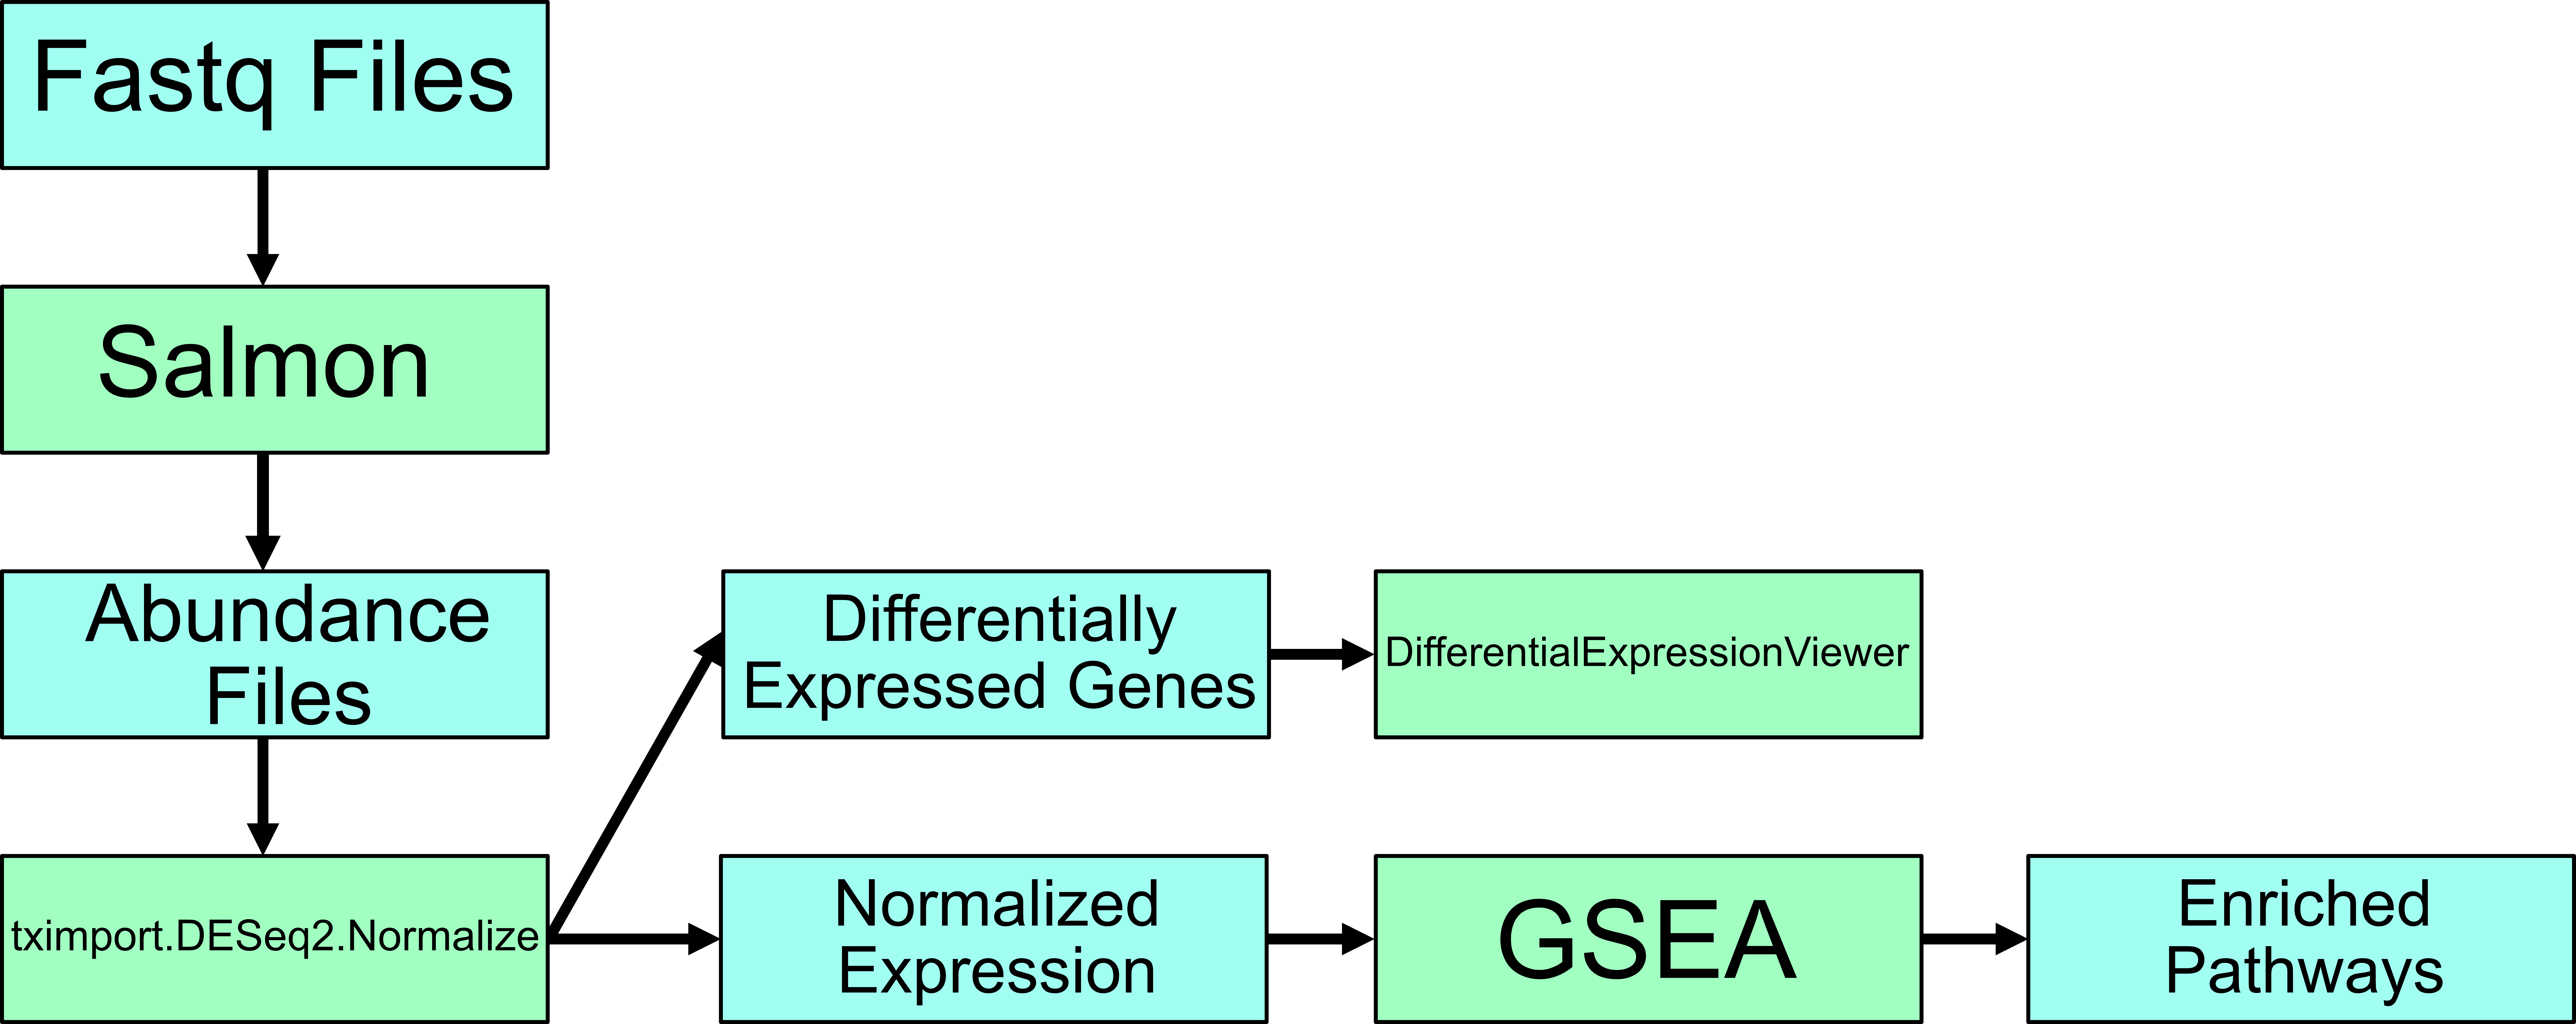

**Instructions in workshop notebooks**

Along with the modules and code cells which encompass an analysis, computational notebooks often include lots of text to provide background, context, and interpretation of the analysis. In this notebook and all other notebooks in this workshop, we will highlight instructions in cells with blue backgrounds. When in doubt on how to proceed with the analysis, look for instruction cells like this one:

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
I am an instruction cell.
</div>

# Activate demo mode

GenePattern modules run "headlessly" in the Cloud. This enhances the ability of the Notebook environment to serve as an encapsulation of the entire scientific workflow, since analysis components that require larger amounts of time or memory can be sent off to appropriately provisioned cloud servers without relying on the continuity of the notebook kernel. This means that, for example, you can start a sequencing alignment job, turn off your notebook, open the notebook hours later, and view the results of the alignment.

Some of the modules in this notebook will take several minutes to hours to run. Therefore, we recommend that you activate "demo mode" for the duration of this workshop. This means that, when you click "Run" on a module, the notebook will first check if there are example job results that match the input parameters, and, if they exist, will immediately return those results to the notebook. This lets us keep to the workshop schedule while keeping the changes to the user experience minimal. If you want to actually run any of these modules with different parameters or inputs, or to just test out running modules, then **do not** click on "Run" in the interface below this cell. If you have demo mode already activated and want to turn it off, then click `Kernel ->  Restart`.

In [13]:
import nbtools
import demo_mode
from IPython.display import display, HTML

## Alex
%load_ext autoreload 
## Alex
%autoreload 2  

@nbtools.build_ui(parameters={'output_var': {'hide': True}})
def activate_demo_mode():
    """Enable demo mode for this notebook"""
    
    # Any job you enable as a demo job will need to be listed here, 
    # along with the module name and any parameters you want matched.
    # Parameters that are not listed will not be matched. You can 
    # list the same module multiple times, assuming you use different 
    # parameter match sets.
    
    """
    demo_mode.set_demo_jobs([
        {
            'name': 'Conos.Preprocess',
            'job': 389201,                                # Make sure to set the permissions of any demo job to 'public'
            'params': {
                'knn': '40',    # Demo mode should be able to match between int and string, but when in doubt use string
                'perplexity': 50
            }
        }, 
        {
            'name': 'Conos.Cluster',
            'job': 389530,
            'params': {
                'conos_object': 'conos_preprocess_output.rds',   # For file parameters, just list the file name, not URL
                'runleiden': 'True'
            }
        }
    ])
    """
    
    demo_mode.set_demo_jobs([
        {
            "name": "Salmon.Quant",
            #"job": 82034,
            "job": 82039,
            "params": {
                #"Reads": "Reads.list.txt",
                "Reads": [
                    "SRR7758650-DMSO_R1.fastq.gz",
                    "SRR7758650-DMSO_R2.fastq.gz",
                    "SRR7758651-DMSO_R1.fastq.gz",
                    "SRR7758651-DMSO_R2.fastq.gz",
                    "SRR7758652-DMSO_R1.fastq.gz",
                    "SRR7758652-DMSO_R2.fastq.gz",
                    "SRR7758653-EPZ6438_R1.fastq.gz",
                    "SRR7758653-EPZ6438_R2.fastq.gz",
                    "SRR7758654-EPZ6438_R1.fastq.gz",
                    "SRR7758654-EPZ6438_R2.fastq.gz",
                    "SRR7758655-EPZ6438_R1.fastq.gz",
                    "SRR7758655-EPZ6438_R2.fastq.gz"
                ]
            }
        },
        {
            "name": "tximport.DESeq2.Normalize",
            "job": 82042,
            "params": {
                "Quantifications": [
                    "SRR7758650-DMSO.quant.sf",
                    "SRR7758651-DMSO.quant.sf",
                    "SRR7758652-DMSO.quant.sf",
                    "SRR7758653-EPZ6438.quant.sf",
                    "SRR7758654-EPZ6438.quant.sf",
                    "SRR7758655-EPZ6438.quant.sf"
                ]
            }
        },
        {
            "name": "CollapseDataset",
            #"job": 82869,
            "job": 82994,
            "params": {
                "dataset.file": "Merged.Data.Normalized.Counts.gct"
            }
        },
        {
            "name": "txt2odf.20211130.colparams",
            #"job": 82577,
            #"job": 82798,
            #"job": 82870,
            #"job": 82987,
            #"job": 82996,
            "job": 82997,
            "params": {
                "txt_file": "Merged.Data.Differential.Expression.txt",
                #"txt_file": "Merged.Data.Differential.Expression_filtered.txt",
                "id_col": "Gene_Symbol"
            }
        },
        {
            "name": "GSEA",
            "job": 82800,
            "params": {
                "expression.dataset": "Merged.Data.Normalized.Counts.gct",
                "gene.sets.database": "c6.all.v7.4.symbols.gmt"
            }
        }
    ])
    
    # To activate demo mode, just call activate(). This example wraps 
    # the activation call behind a UI Builder cell, but you could have 
    # it called in different ways.

    demo_mode.activate()
    display(HTML('<div class="alert alert-success">Demo mode activated</div>'))
    
    # The code in this call has been left expanded for tutorial purposes

UIBuilder(description='Enable demo mode for this notebook', function_import='nbtools.tool(id="activate_demo_mo…

# Login to GenePattern

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
Instructions for inserting a GP login cell.
</div>

In [1]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://beta.genepattern.org/gp", "", ""))

GPAuthWidget()

# Get transcript abundances with Salmon

Here we will run the Salmon.Quant module, the GenePattern module that implements the Salmon pseudoalignment tool, a much faster approach to traditional sequencing alignment, which looks for read segments that match overlapping segments of the transcriptome rather than a base-pair-to-base-pair matching. Salmon.Quant needs a valid Salmon transcriptome index to use as a reference. GenePattern has prebuilt references for Human and Mouse transcriptomes. If you have sequencing data from another organism, you can build your own Salmon index with the Salmon.Indexer GenePattern module.

**Note**: If you are analyzing your own data and you already have abundances derived from a pseudoaligner like Salmon or Kallisto, you can skip this step.

**Input data**

These URLs point to each of the input files, which are paired `fastq` files for a total of 6 samples. You don't have to download these files, they can be passed the first module using these URLs.

In [2]:
from nbtools import UIBuilder, UIOutput

UIOutput(
    name = "FASTQ input files from GSE1119088",
    files = [
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758650-DMSO_R1.fastq.gz",
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758650-DMSO_R2.fastq.gz",
        
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758651-DMSO_R1.fastq.gz",
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758651-DMSO_R2.fastq.gz",
        
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758652-DMSO_R1.fastq.gz",
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758652-DMSO_R2.fastq.gz",
        
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758653-EPZ6438_R1.fastq.gz",
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758653-EPZ6438_R2.fastq.gz",
        
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758654-EPZ6438_R1.fastq.gz",
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758654-EPZ6438_R2.fastq.gz",
        
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758655-EPZ6438_R1.fastq.gz",
        "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758655-EPZ6438_R2.fastq.gz"
    ]
)

UIOutput(files=['https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758650-DMSO_R1.fastq.g…

**Salmon Index**

In [3]:
UIOutput(
    name = "Gencode v37 Salmon Index",
    files = [
        "https://datasets-genepattern-org.s3.amazonaws.com/data/test_data/Salmon/gencode.v37.annotation.k31.salmon_full_decoy_index.tar.gz"
    ]
)

UIOutput(files=['https://datasets-genepattern-org.s3.amazonaws.com/data/test_data/Salmon/gencode.v37.annotatio…

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
Insert a Salmon.Quant module.
    <ol>
        <li>Create a new cell below this one using the <b>+</b> button.</li>
        <li>Click on "Cell -> CellType -> GenePattern".</li>
        <li>Search for "Salmon.Quant" and choose the Salmon.Quant module from the list.</li>
        <li>Add each of the <code>fastq.gz</code> links above to the <code>Reads*</code> parameter field.</li>
        <li>Add the Salmon Index link above to the <code>Transcriptome Index*</code> parameter field.</li> 
        <li>Click "Run".</li>
    </ol>
</div>

In [4]:
salmon_quant_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:genepattern.org:module.analysis:00420')
salmon_quant_job_spec = salmon_quant_task.make_job_spec()
salmon_quant_job_spec.set_parameter("Reads", ["https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758650-DMSO_R1.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758650-DMSO_R2.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758651-DMSO_R1.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758651-DMSO_R2.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758652-DMSO_R1.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758652-DMSO_R2.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758653-EPZ6438_R1.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758653-EPZ6438_R2.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758654-EPZ6438_R1.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758654-EPZ6438_R2.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758655-EPZ6438_R1.fastq.gz", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/SRR7758655-EPZ6438_R2.fastq.gz"])
salmon_quant_job_spec.set_parameter("Transcriptome.Index", "https://datasets.genepattern.org/data/test_data/Salmon/gencode.v37.annotation.k31.salmon_full_decoy_index.tar.gz")
salmon_quant_job_spec.set_parameter("Library.Type", "A")
salmon_quant_job_spec.set_parameter("Sampling", "BOOT")
salmon_quant_job_spec.set_parameter("seqBias", "true")
salmon_quant_job_spec.set_parameter("gcBias", "true")
salmon_quant_job_spec.set_parameter("posBias", "true")
salmon_quant_job_spec.set_parameter("N.Sampling", "30")
salmon_quant_job_spec.set_parameter("Mimic.Bowtie", "off")
salmon_quant_job_spec.set_parameter("Recover.Orphans", "false")
salmon_quant_job_spec.set_parameter("Hard.Filter", "false")
salmon_quant_job_spec.set_parameter("Allow.Dovetail", "false")
salmon_quant_job_spec.set_parameter("Dump.EQ", "false")
salmon_quant_job_spec.set_parameter("reduce.GC.Memory", "false")
salmon_quant_job_spec.set_parameter("Range.Factorization", "false")
salmon_quant_job_spec.set_parameter("Range.Factorization.Bins", "4")
salmon_quant_job_spec.set_parameter("biasSpeedSamp", "false")
salmon_quant_job_spec.set_parameter("biasSpeedSamp.Factor", "5")
salmon_quant_job_spec.set_parameter("job.memory", "16Gb")
salmon_quant_job_spec.set_parameter("job.queue", "gp-new-beta")
salmon_quant_job_spec.set_parameter("job.cpuCount", "3")
salmon_quant_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(salmon_quant_task)

GPTaskWidget(lsid='urn:lsid:genepattern.org:module.analysis:00420')

# Get gene counts and differentially expressed genes

Now that we have the quantifications of transcript abundance, we can explore the changes in expression in the treated samples relative to the control. To do this, we start by running the tximport.DESeq2.Normalize module, which combines the functionality of the tximport and DESeq2 software tools. tximport aggregates the transcript-level abundance estimates to gene-level estimated counts, which are then appropriate for input to DESeq2, which tests for gene-level differential expression. Finally, this module also gives us the expression matrix transformed according to DESeq2's "median of ratios" normalization which it performs prior to testing for differential expression. We find that this normalization leads to optimal performance for Gene Set Enrichment Analysis (GSEA), which we will revisit later in this notebook.

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
Insert and run tximport.DESeq2.Normalize
    <ol>
        <li>Create a new cell below this one using the <b>+</b> button.</li>
        <li>Click on "Cell -> CellType -> GenePattern".</li>
        <li>Search for "tximport.DESeq2.Normalize" and choose the tximport.DESeq2.Normalize module.</li>
        <li>Select each one from the dropdown for the <code>Quantifications*</code> parameter field.</li>
        <li>In the <code>Sample Info</code> field, choose <code>2021-11-16_intro-to-gp_tximport-sample-info.txt</code>.</li>
        <li>In the <code>transcriptome database</code> parameter, choose <code>gencode.v37.annotation.gtf.gz</code>.
        <li>Set the <code>Reverse Sign*</code> parameter to "TRUE".</li>
    </ol>
</div>

**Sample Info**

In [5]:
UIOutput(
    name = "DESeq2 Sample Info",
    files = ["https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/2021-11-16_intro-to-gp_tximport-sample-info.txt"]
)

UIOutput(files=['https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/2021-11-16_intro-to-gp_txi…

**Transcriptome database**

In [6]:
UIOutput(
    name = "Gencode v37 GTF",
    files = ["https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_37/gencode.v37.annotation.gtf.gz"]
)

UIOutput(files=['https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_37/gencode.v37.annotation.g…

In [7]:
tximport_deseq2_normalize_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:179')
tximport_deseq2_normalize_job_spec = tximport_deseq2_normalize_task.make_job_spec()
tximport_deseq2_normalize_job_spec.set_parameter("Quantifications", ["https://beta.genepattern.org/gp/jobResults/82039/SRR7758650-DMSO.quant.sf", "https://beta.genepattern.org/gp/jobResults/82039/SRR7758651-DMSO.quant.sf", "https://beta.genepattern.org/gp/jobResults/82039/SRR7758652-DMSO.quant.sf", "https://beta.genepattern.org/gp/jobResults/82039/SRR7758653-EPZ6438.quant.sf", "https://beta.genepattern.org/gp/jobResults/82039/SRR7758654-EPZ6438.quant.sf", "https://beta.genepattern.org/gp/jobResults/82039/SRR7758655-EPZ6438.quant.sf"])
tximport_deseq2_normalize_job_spec.set_parameter("Sample.Info", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/2021-11-16_intro-to-gp_tximport-sample-info.txt")
tximport_deseq2_normalize_job_spec.set_parameter("Quant.Type", "SALMON")
tximport_deseq2_normalize_job_spec.set_parameter("Transcriptome.Database", "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_37/gencode.v37.annotation.gtf.gz")
tximport_deseq2_normalize_job_spec.set_parameter("Output.Normalized.Counts", "TRUE")
tximport_deseq2_normalize_job_spec.set_parameter("Output.TPM", "TRUE")
tximport_deseq2_normalize_job_spec.set_parameter("output.file.base", "Merged.Data")
tximport_deseq2_normalize_job_spec.set_parameter("Reverse.Sign", "TRUE")
tximport_deseq2_normalize_job_spec.set_parameter("Annotate.DEGs", "TRUE")
tximport_deseq2_normalize_job_spec.set_parameter("Split.Identifiers", "TRUE")
tximport_deseq2_normalize_job_spec.set_parameter("Min.Count.Filter", "1")
tximport_deseq2_normalize_job_spec.set_parameter("random.seed", "779948241")
tximport_deseq2_normalize_job_spec.set_parameter("job.memory", "2 Gb")
tximport_deseq2_normalize_job_spec.set_parameter("job.queue", "gp-new-beta")
tximport_deseq2_normalize_job_spec.set_parameter("job.cpuCount", "1")
tximport_deseq2_normalize_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(tximport_deseq2_normalize_task)


GPTaskWidget(lsid='urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:179'…

# Visualize differential expression results

Here, we will use the DifferentialExpressionViewer GenePattern module to render a visualization of significantly differentially expressed genes within the notebook. This requires us to make a number of modifications to the data. Here, we will do the following:
1. Convert from Ensembl gene IDs to gene symbols using `CollapseDataset`.
2. Generate an "ODF" file based on the DESeq2 results.
3. Remove missing genes from the ODF and expression GCT file.


## Convert from Ensembl to gene symbols

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
    <ol>
        <li>Insert a new cell below</li>
        <li>Change the cell to a GenePattern cell, and choose the CollapseDataset module.</li>
        <li>In the <code>dataset file*</code> field, choose <code>Merged.Data.Normalized.Counts.gct</code>.</li>
        <li>In the <code>chip platform</code> field, choose <code>Human_ENSEMBL_Gene_ID_MSigDB.v.7.4.chip</code>.</li>
        <li>In the <code>output file name*</code> field, write <code>Merged.Data.Normalized.Counts_collapsed.gct</code>.</li>
    </ol>
</div>

In [8]:
collapsedataset_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00134')
collapsedataset_job_spec = collapsedataset_task.make_job_spec()
collapsedataset_job_spec.set_parameter("dataset.file", "https://beta.genepattern.org/gp/jobResults/82042/Merged.Data.Normalized.Counts.gct")
collapsedataset_job_spec.set_parameter("chip.platform", "ftp://ftp.broadinstitute.org/pub/gsea/annotations_versioned/Human_ENSEMBL_Gene_ID_MSigDB.v7.4.chip")
collapsedataset_job_spec.set_parameter("collapse.mode", "Max_probe")
collapsedataset_job_spec.set_parameter("output.file.name", "Merged.Data.Normalized.Counts_collapsed.gct")
collapsedataset_job_spec.set_parameter("omit.features.with.no.symbol.match", "true")
collapsedataset_job_spec.set_parameter("dev.mode", "false")
collapsedataset_job_spec.set_parameter("job.memory", "4 Gb")
collapsedataset_job_spec.set_parameter("job.queue", "gp-new-beta")
collapsedataset_job_spec.set_parameter("job.cpuCount", "1")
collapsedataset_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(collapsedataset_task)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00134')

## Generate ODF file for DifferentialExpressionViewer

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
<ol>
    <li>Insert a new cell below, change it to a GenePattern cell, and choose DESeq2ToODF.</li>
    <li>In the <code>txt file*</code> field, choose <code>Merged.Data.Differential.Expression.txt</code>.</li>
    <li>In the <code>id col*</code> field, write <code>Gene_Symbol</code>.</li>
    <li>In the <code>stat*</code> field, write <code>Wald statistic: Factor EPZ6438 vs DMSO</code>.</li>
    <li>Set the <code>prune gct*</code> field to <code>True</code>.</li>
    <li>In the <code>gct</code> field, choose <code>Merged.Data.Normalized_collapsed_to_symbols.gct</code>.</li>
    <li>In the <code>cls</code> field, choose <code>Merged.Data.cls</code>.</li>
</ol>
    
</div>

In [9]:
txt2odf_20211130_colparams_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:543')
txt2odf_20211130_colparams_job_spec = txt2odf_20211130_colparams_task.make_job_spec()
txt2odf_20211130_colparams_job_spec.set_parameter("txt_file", "https://beta.genepattern.org/gp/jobResults/82042/Merged.Data.Differential.Expression.txt")
txt2odf_20211130_colparams_job_spec.set_parameter("id_col", "Gene_Symbol")
txt2odf_20211130_colparams_job_spec.set_parameter("stat", "Wald statistic: Factor EPZ6438 vs DMSO")
txt2odf_20211130_colparams_job_spec.set_parameter("prune_gct", "True")
txt2odf_20211130_colparams_job_spec.set_parameter("gct", "https://beta.genepattern.org/gp/jobResults/82994/Merged.Data.Normalized_collapsed_to_symbols.gct")
txt2odf_20211130_colparams_job_spec.set_parameter("cls", "https://beta.genepattern.org/gp/jobResults/82042/Merged.Data.cls")
txt2odf_20211130_colparams_job_spec.set_parameter("job.memory", "2 Gb")
txt2odf_20211130_colparams_job_spec.set_parameter("job.queue", "gp-new-beta")
txt2odf_20211130_colparams_job_spec.set_parameter("job.cpuCount", "1")
txt2odf_20211130_colparams_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(txt2odf_20211130_colparams_task)

GPTaskWidget(lsid='urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:543'…

## Remove missing genes

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
<ol>
    <li>In the <code>DESeq2ToODF ODF file*</code> field, choose <code>Merged.Data.Differential.Expression.odf</code>.</li>
    <li>In the <code>DESeq2ToODF GCT file*</code> field, choose <code>Merged.Data.Differential.Expression_pruned.gct</code>.</li>
    <li>Click Run.</li>
</ol>
</div>

In [14]:
from gp.data import GCT, ODF, write_gct, write_odf, _parse_header

import os
import pandas as pd
import requests

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

def get_gp_file(gpserver, url):
    """
    General file retrieval from gp server
    """
    f = gp.GPFile(gpserver, url)
    
    basename = os.path.basename(url)
    
    resp = requests.get(url, headers={
        'Authorization': f.server_data.authorization_header(), 
        'User-Agent': 'GenePatternRest'
    })
    
    with open(basename, "wb") as f:
        f.write(resp.content)
        
    return basename

@genepattern.build_ui(name="Remove missing genes", parameters={
    "odf_url": {
        "name": "DESeq2ToODF ODF file",
        "description": "The ODF file from DESeq2ToODF output ODF file",
        "type": "file",
        "kinds": [".Expression.odf"]
    },
    "gct_url": {
        "name": "DESeq2ToODF GCT file",
        "description": "Pruned GCT file from DESeq2ToODF output",
        "type": "file",
        "kinds": ["_pruned.gct"]
    },
    "output_var": {
        "default":"output_var",
        "hide": True
    }
})
def remove_missing_genes(odf_url, gct_url):
    ## Initialize API connection
    gpserver = genepattern.session.get(0)
    
    ## Get ODF from GP
    odf_local_path = get_gp_file(gpserver, odf_url)
    odf_df = ODF(odf_local_path)

    ## Get GCT from GP
    gct_local_path = get_gp_file(gpserver, gct_url)
    gct_df = GCT(gct_local_path)
    
    ## Get intersecting symbols
    shared_symbols = list(set(odf_df["Feature"]).intersection(gct_df.index.get_level_values(0)))
    
    ## Drop duplicate gene symbols
    odf_short_df = odf_df[odf_df["Feature"].isin(shared_symbols)]
    odf_short_df = odf_short_df.drop_duplicates(subset = "Feature", keep = "first")
    
    ## Subset to common genes
    gct_short_df = gct_df[gct_df.index.isin(shared_symbols, level = 0)]
    gct_short_df = gct_short_df[~gct_short_df.index.duplicated(keep = 'first')]
    
    ## Generate paths for outputs
    new_odf_path = odf_local_path.strip(".odf") + "_filtered.odf"
    new_gct_path = gct_local_path.strip(".gct") + "_filtered.gct"
    
    ## Reset ranks in ODF
    odf_short_df["Rank"] = list(range(1, odf_short_df.shape[0] + 1))
    
    ## Save output ODF
    with open(odf_local_path) as odf_file:
        headers = [next(odf_file) for x in range(21)]
        headers[-1] = f"DataLines={odf_short_df.shape[0]}\n"
        open(new_odf_path, 'w').writelines(headers)
        odf_short_df.to_csv(new_odf_path, header = False, mode = 'a', sep = '\t', index = False)
    
    ## Remove extra newline in ODF 
    new_odf_lines = open(new_odf_path, 'r').readlines()
    new_odf_lines[-1] = new_odf_lines[-1].strip('\n')
    open(new_odf_path, 'w').writelines(new_odf_lines)

    ## Save output GCT
    write_gct(gct_short_df, new_gct_path)
    
    ## Upload to GP
    gct_url = gpserver.upload_file(new_gct_path, new_gct_path).get_url()
    odf_url = gpserver.upload_file(new_odf_path, new_odf_path).get_url()
    
    display(
        UIOutput(
            name = "Filtered GCT and ODF files",
            files = [odf_url, gct_url]
        )
    )

UIBuilder(function_import='nbtools.tool(id="Remove missing genes", origin="Notebook").function_or_method', nam…

## Render heatmap with DifferentialExpressionViewer

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
<ol>
    <li>In the <code>differential expression filename*</code> field, choose <code>Merged.Data.Differential.Expression_filtered.odf</code>.</li>
    <li>In the <code>dataset filename*</code> field, choose <code>Merged.Data.Differential.Expression_pruned_filtered.gct</code>.</li>
    <li>Click Run</li>
</ol>
</div>

In [10]:
differentialexpressionviewer_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.visualizer:00045')
differentialexpressionviewer_job_spec = differentialexpressionviewer_task.make_job_spec()
differentialexpressionviewer_job_spec.set_parameter("differential.expression.filename", "https://beta.genepattern.org/gp/users/atwenzel2/tmp/run4829612710481845075.tmp/Merged.Data.Differential.Expression_filtered.odf")
differentialexpressionviewer_job_spec.set_parameter("dataset.filename", "https://beta.genepattern.org/gp/users/atwenzel2/tmp/run2677630213872022988.tmp/Merged.Data.Differential.Expression_pruned_filtered.gct")
differentialexpressionviewer_job_spec.set_parameter("job.memory", "2 Gb")
differentialexpressionviewer_job_spec.set_parameter("job.queue", "gp-new-beta")
differentialexpressionviewer_job_spec.set_parameter("job.cpuCount", "1")
differentialexpressionviewer_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(differentialexpressionviewer_task)

job83032 = gp.GPJob(genepattern.session.get(0), 83032)
genepattern.display(job83032)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.visualizer:00045')

GPJobWidget(job_number=83032)

# Find dysregulated pathways with GSEA

Based on the above results, we can conclude that the inhibition of *EZH2* has caused extensive dysregulation. Because so many genes are differentially expressed, it can be difficult to identify which pathways are most likely to be affected by these changes. Here, we will use Gene Set Enrichment Analysis (GSEA) to test for significantly up- or down-regulated pathways. Specifically, we will investigate the oncogenic signatures gene set collection. A link to those signatures is below:

In [11]:
display(
    UIOutput(
        name = "C6 Oncogenic Signatures Collection",
        files = ["https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/c6.all.v7.4.symbols.gmt"]
    )
)

UIOutput(files=['https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/c6.all.v7.4.symbols.gmt'],…

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
<ol>
    <li>In the <code>expression dataset*</code> parameter, choose <code>Merged.Data.Differential.Expression_pruned_filtered.gct</code>.</li>
    <li>In the <code>gene sets database*</code>, choose <code>c6.all.v7.4.symbols.gmt</code>.</li>
    <li>In the <code>number of permutations*,</code> field, enter 1,000.</li>
    <li>In the <code>phenotype labels*</code> field, choose <code>Merged.Data.cls</code>.</li>
    <li>In the <code>permutation type*</code> field, choose <code>gene_set</code>.</li>
    <li>In the <code>collapse dataset*</code> field, choose <code>Collapse</code>.</li>
    <li>In the <code>chip platform file</code> field, choose <code>Human_Gene_Symbol_with_Remapping_MSigDB.v7.4.chip</code>.</li>
</ol>
</div>

In [12]:
gsea_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00072')
gsea_job_spec = gsea_task.make_job_spec()
gsea_job_spec.set_parameter("expression.dataset", "https://beta.genepattern.org/gp/users/atwenzel2/tmp/run2677630213872022988.tmp/Merged.Data.Differential.Expression_pruned_filtered.gct")
gsea_job_spec.set_parameter("gene.sets.database", "https://datasets.genepattern.org/data/Workshop_12152021/BulkRNASeq/c6.all.v7.4.symbols.gmt")
gsea_job_spec.set_parameter("number.of.permutations", "10")
gsea_job_spec.set_parameter("phenotype.labels", "https://beta.genepattern.org/gp/jobResults/82042/Merged.Data.cls")
gsea_job_spec.set_parameter("target.profile", "")
gsea_job_spec.set_parameter("permutation.type", "gene_set")
gsea_job_spec.set_parameter("collapse.dataset", "Collapse")
gsea_job_spec.set_parameter("chip.platform.file", "ftp://ftp.broadinstitute.org/pub/gsea/annotations_versioned/Human_Gene_Symbol_with_Remapping_MSigDB.v7.4.chip")
gsea_job_spec.set_parameter("output.file.name", "<expression.dataset_basename>.zip")
gsea_job_spec.set_parameter("scoring.scheme", "weighted")
gsea_job_spec.set_parameter("metric.for.ranking.genes", "Signal2Noise")
gsea_job_spec.set_parameter("gene.list.sorting.mode", "real")
gsea_job_spec.set_parameter("gene.list.ordering.mode", "descending")
gsea_job_spec.set_parameter("max.gene.set.size", "500")
gsea_job_spec.set_parameter("min.gene.set.size", "15")
gsea_job_spec.set_parameter("collapsing.mode.for.probe.sets.with.more.than.one.match", "Max_probe")
gsea_job_spec.set_parameter("normalization.mode", "meandiv")
gsea_job_spec.set_parameter("randomization.mode", "no_balance")
gsea_job_spec.set_parameter("omit.features.with.no.symbol.match", "true")
gsea_job_spec.set_parameter("median.for.class.metrics", "false")
gsea_job_spec.set_parameter("number.of.markers", "100")
gsea_job_spec.set_parameter("random.seed", "timestamp")
gsea_job_spec.set_parameter("save.random.ranked.lists", "false")
gsea_job_spec.set_parameter("selected.gene.sets", "")
gsea_job_spec.set_parameter("dev.mode", "false")
gsea_job_spec.set_parameter("alt.delim", "")
gsea_job_spec.set_parameter("plot.graphs.for.the.top.sets.of.each.phenotype", "20")
gsea_job_spec.set_parameter("make.detailed.gene.set.report", "true")
gsea_job_spec.set_parameter("create.svgs", "false")
gsea_job_spec.set_parameter("create.gcts", "false")
gsea_job_spec.set_parameter("create.zip", "true")
gsea_job_spec.set_parameter("job.memory", "8 Gb")
gsea_job_spec.set_parameter("job.queue", "gp-new-beta")
gsea_job_spec.set_parameter("job.cpuCount", "1")
gsea_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(gsea_task)

job83036 = gp.GPJob(genepattern.session.get(0), 83036)
genepattern.display(job83036)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00072')

GPJobWidget(job_number=83036)

# References

1. Huang, X., Yan, J., Zhang, M., Wang, Y., Chen, Y., Fu, X., Wei, R., Zheng, X. ling, Liu, Z., Zhang, X., Yang, H., Hao, B., Shen, Y. yan, Su, Y., Cong, X., Huang, M., Tan, M., Ding, J., & Geng, M. (2018). Targeting Epigenetic Crosstalk as a Therapeutic Strategy for EZH2-Aberrant Solid Tumors. Cell, 175(1), 186-199.e19. https://doi.org/10.1016/j.cell.2018.08.058

2. Li, S., Noor, Z. S., Zeng, W., Stackpole, M. L., Ni, X., Zhou, Y., Yuan, Z., Wong, W. H., Agopian, V. G., Dubinett, S. M., Alber, F., Li, W., Garon, E. B., & Zhou, X. J. (2021). Sensitive detection of tumor mutations from blood and its application to immunotherapy prognosis. Nature Communications, 12(1). https://doi.org/10.1038/s41467-021-24457-2
